In [120]:
# Since the flights data is only updated once a month, here we are trying different ways 
# for filling na's until next month's data is released

In [16]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import math
import itertools
import datetime
#from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [17]:
# We now read the exogenous data (for now, from a local file)

exogenous = pd.read_csv('./data/exogenas.csv', parse_dates=[0], index_col=[0])

In [18]:
country = 'Italy'
variable = 'new_cases'
initialdate = '01-01-2020'
enddate = '31-07-2020' 

# We now need to filter the country/dates, and aply 7-day rolling mean:

exogenous_ctry = exogenous.loc[:, exogenous.columns.str.contains(country)]
#exogenous_ctry = exogenous_ctry.loc[initialdate:]

# We apply the 7-day rolling mean, as in the endogenous data
exogenous_ctryR = exogenous_ctry.rolling(7).mean()
exogenous_ctryR = exogenous_ctryR.loc['2020-01-07':]

In [19]:
exogenous_ctryR.head()

,schoolclosing_Italy,workplaceclosing_Italy,cancelpublicevents_Italy,restrictionsongatherings_Italy,closepublictransport_Italy,stayathomerequirements_Italy,domestictravel_Italy,internationaltravel_Italy,publicinfocampaign_Italy,testingpolicy_Italy,contacttracing_Italy,mask_Italy,FlightsArr_Italy
2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1509.285714
2020-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1520.142857
2020-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1497.857143
2020-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1487.142857
2020-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1455.000000


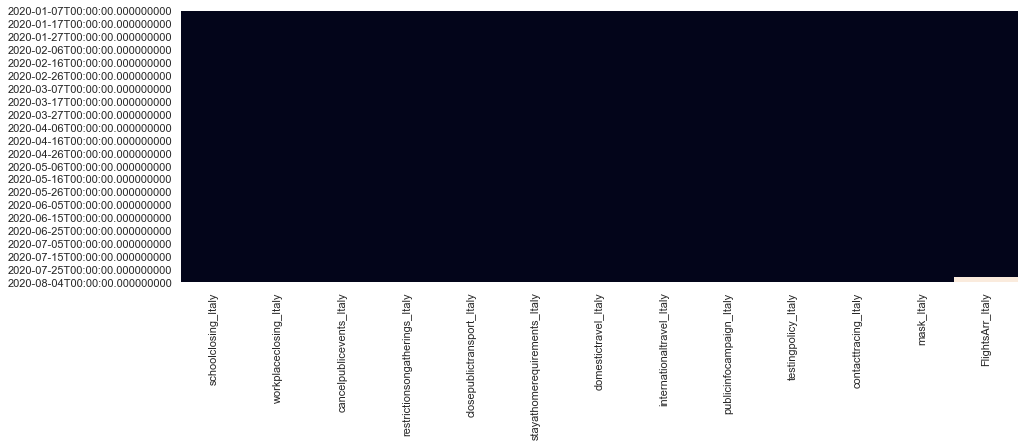

In [5]:
# Interesting plot for looking at nans across a dataset
sns.heatmap(exogenous_ctryR.isnull(), cbar=False)

In [20]:
exogenous_ctryR_flights = exogenous_ctryR.loc[:, exogenous_ctryR.columns.str.contains('Flights')]

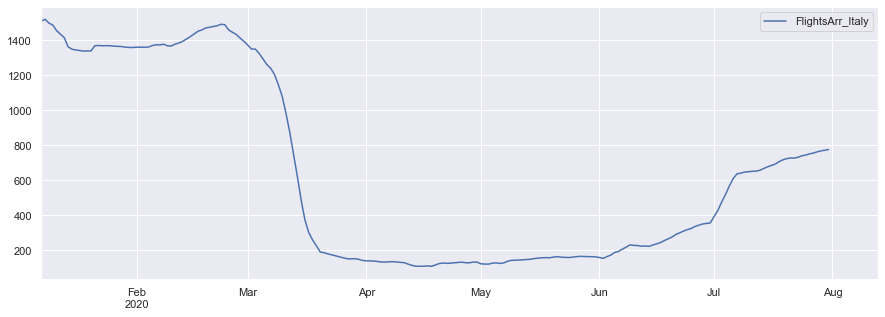

In [27]:
exogenous_ctryR_flights.plot()

In [22]:
# Extend indexes at the beginning and end
new_index = pd.date_range('2019-12-01', '2020-08-13', freq='D')
new_index

DatetimeIndex(['2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10',
               ...
               '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07',
               '2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11',
               '2020-08-12', '2020-08-13'],
              dtype='datetime64[ns]', length=257, freq='D')

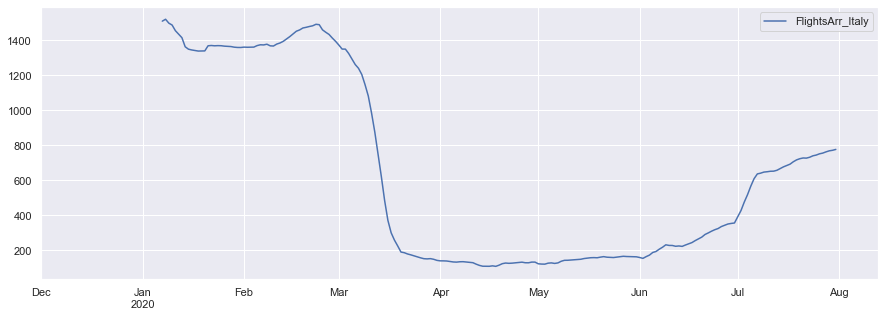

In [28]:
# Reindex data with above new index
exogenous_ctryR_flightsI = exogenous_ctryR_flights.reindex(new_index)
exogenous_ctryR_flightsI.plot()

            FlightsArr_Italy
2020-07-25        744.714286
2020-07-26        751.857143
2020-07-27        756.000000
2020-07-28        763.000000
2020-07-29        769.000000
2020-07-30        772.000000
2020-07-31        777.000000
2020-08-01        777.000000
2020-08-02        777.000000
2020-08-03        777.000000
2020-08-04        777.000000
2020-08-05        777.000000
2020-08-06        777.000000
2020-08-07        777.000000
2020-08-08        777.000000
2020-08-09        777.000000
2020-08-10        777.000000
2020-08-11        777.000000
2020-08-12        777.000000
2020-08-13        777.000000


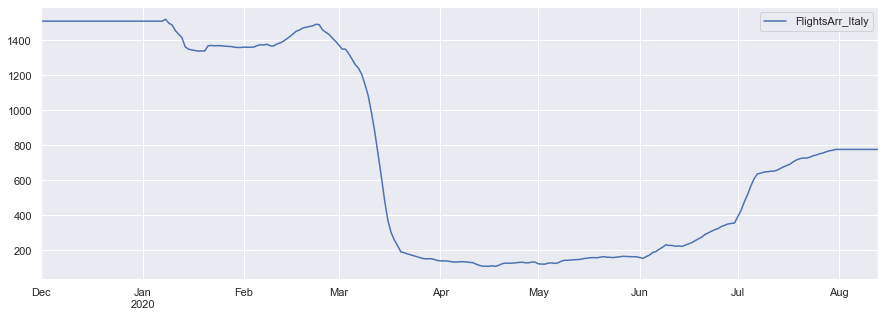

In [31]:
# Use interpolate to fill nas at the beginning and end
method = 'linear'
exogenous_ctryR_flightsI.interpolate(method=method, limit_direction='both').plot()
print(exogenous_ctryR_flightsI.interpolate(method=method, limit_direction='both').tail(20))

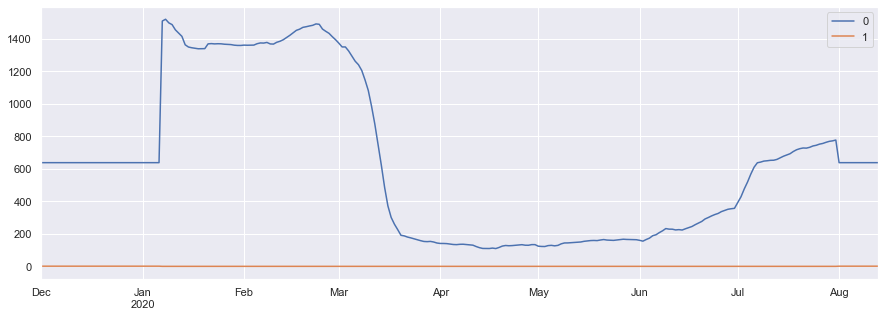

In [32]:
# Tried SimpleImputer, but there is very little strategies options, so doesn't add any value
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp_mean_fpd = pd.DataFrame(imp_mean.fit_transform(exogenous_ctryR_flightsI), index=exogenous_ctryR_flightsI.index)
imp_mean_fpd.plot()

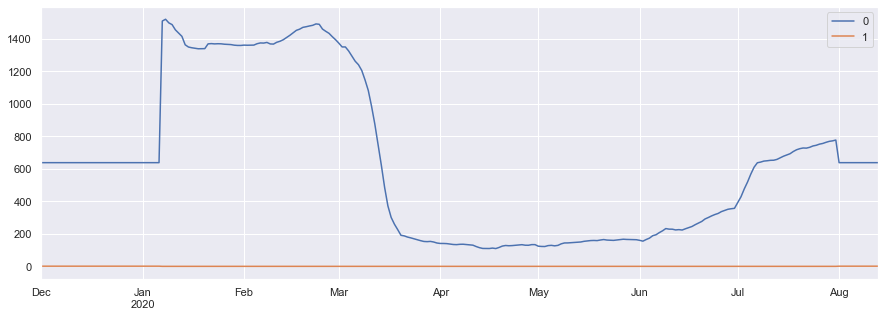

In [35]:
# Looks like not working... might need to update scikit-learn, but don't want to run into environment inconsistencies...
from sklearn.impute import KNNImputer
imp_knn = KNNImputer(n_neighbors=2, weights='distance', add_indicator=True)
imp_knn_fpd = pd.DataFrame(imp_knn.fit_transform(exogenous_ctryR_flightsI), index=exogenous_ctryR_flightsI.index)
imp_knn_fpd.plot()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1530.696, BIC=1544.007, Time=0.068 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1917.299, BIC=1923.955, Time=0.008 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1528.731, BIC=1538.715, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1740.736, BIC=1750.719, Time=0.064 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1919.373, BIC=1922.701, Time=0.004 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1530.683, BIC=1543.995, Time=0.044 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1532.487, BIC=1549.126, Time=0.132 seconds
Total fit time: 0.348 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -761.366
Date:                Tue, 18 Aug 2020   AIC  

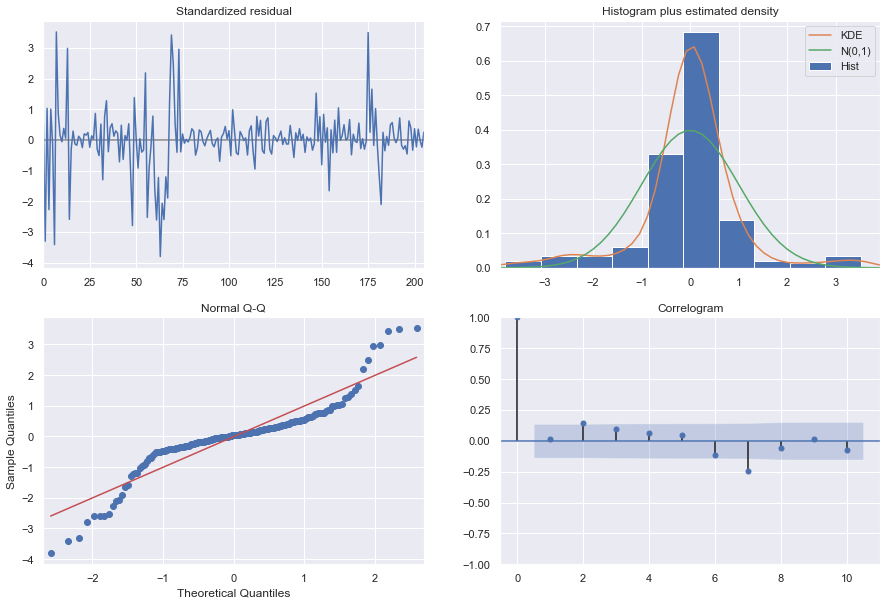

In [88]:
modelauto = pm.auto_arima(exogenous_ctryR_flights.dropna(), start_p=1, start_q=1,
                      test='adf',       # use kpss to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                    # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelauto.summary())
modelauto.plot_diagnostics(figsize=(15,10))
plt.show()

In [89]:
pred = modelauto.predict(40)

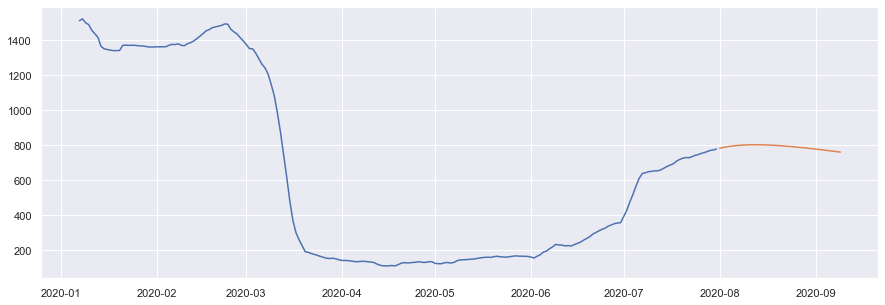

In [90]:
plt.plot(exogenous_ctryR_flights.index, exogenous_ctryR_flights)
plt.plot(pd.DataFrame(pred, index=pd.date_range('2020-08-01', '2020-09-09', freq='D')))
plt.show()

In [122]:
# Tried with different countries and due to the amount of data we have (little), 
# the prediction doesn't add much value... it takes time and a simple interpolate seems like a quick and good solution

In [36]:
import sklearn
sklearn.__version__

'0.22.1'